<a href="https://colab.research.google.com/github/titaofdata/Week-10-Models-Used-in-Industries/blob/main/IntroRecommendationEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Engines  
A recommendation system is a subclass of information filtering system that seeks to predict the “rating” or “preference” a user would give to an item.  

Practically speaking, this system provides you items or products based on your past purchases or interests.

### Types of making recommendation systems?

- Content-based recommendation — based on product attributes
- Collaborative filtering — based on similar users

### Content based recommendation:

System use the knowledge of each product to recommend a new product.

Example: If you are interested to watch a romantic movie, then the system would recommend you the list of movies in that genre.

It works well if you have descriptive data available for the product you have to recommend.

### Collaborative filtering:

System don’t have any knowledge about the product but it recommend only based on the user’s rating in the past.

Example: Consider that you rated a list of movies. If you gave 4.5/5 for an horror movie and 1.5 for an adventure movie, then the system would recommend horror movies in the future.

Reference: [link](https://medium.com/coinmonks/recommendation-engine-python-401c080c583e)

Now let us move on to the steps for building a system.

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import io

### Install Surprise 
Surprise is python scikit building and analyzing recommender systems.

In [2]:
!pip install surprise

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl size=771642 sha256=37f967def20b0b9296a89cd18c5f178258e62f3beb9a3dbb12bb63eef570403e
  Stored in directory: c:\users\admin2\appdata\local\pip\cache\wheels\76\44\74\b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import get_dataset_dir
from surprise.model_selection import KFold

### Load Dataset  
GroupLens Research has collected and made available rating data sets from the MovieLens [website](http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set.

In [4]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\admin2/.surprise_data/ml-100k


In [5]:
file_path = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.data')
read_data = pd.read_csv(file_path, '\t', names = ['user', 'item', 'rating', 'timestamp'])

read_data.head()


,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# Use the famous SVD algorithm.
algo = SVD()


In [7]:
# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9386  0.9354  0.9376  0.9448  0.9265  0.9366  0.0059  
MAE (testset)     0.7396  0.7362  0.7368  0.7477  0.7311  0.7383  0.0054  
Fit time          5.51    5.44    5.64    5.64    5.47    5.54    0.08    
Test time         0.23    0.15    0.16    0.21    0.15    0.18    0.03    


{'test_rmse': array([0.93858198, 0.93539632, 0.93764301, 0.94482162, 0.92651513]),
 'test_mae': array([0.73958617, 0.73622615, 0.73684406, 0.74766993, 0.73108726]),
 'fit_time': (5.513714551925659,
  5.442480564117432,
  5.63617205619812,
  5.637964963912964,
  5.473106861114502),
 'test_time': (0.22664284706115723,
  0.15340828895568848,
  0.15746164321899414,
  0.2065443992614746,
  0.1534442901611328)}

### Actual Movie Name Mapping

In [8]:
def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [9]:
rid_to_name, name_to_rid = read_item_names()

### Get Watched Movies by a Specific User

In [10]:
user_trial = "6"

In [11]:
[rid_to_name[str(i)] for i in read_data.groupby('user')['item'].apply(list)[int(user_trial)]][:10]

['Remains of the Day, The (1993)',
 'Postino, Il (1994)',
 'Silence of the Lambs, The (1991)',
 'Secret of Roan Inish, The (1994)',
 'In & Out (1997)',
 'Contact (1997)',
 'Forrest Gump (1994)',
 'Manhattan (1979)',
 'Taxi Driver (1976)',
 'East of Eden (1955)']

### Get Top *N* Recommendations per User

In [12]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [13]:
trainset = data.build_full_trainset()

algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)


In [14]:
predictions

[Prediction(uid='196', iid='302', r_ui=3.52986, est=4.212118037212345, details={'was_impossible': False}),
 Prediction(uid='196', iid='377', r_ui=3.52986, est=2.9200336487943312, details={'was_impossible': False}),
 Prediction(uid='196', iid='51', r_ui=3.52986, est=3.47372703437081, details={'was_impossible': False}),
 Prediction(uid='196', iid='346', r_ui=3.52986, est=3.5638539529932234, details={'was_impossible': False}),
 Prediction(uid='196', iid='474', r_ui=3.52986, est=4.195122809708869, details={'was_impossible': False}),
 Prediction(uid='196', iid='265', r_ui=3.52986, est=3.6233183024499116, details={'was_impossible': False}),
 Prediction(uid='196', iid='465', r_ui=3.52986, est=3.695863019993495, details={'was_impossible': False}),
 Prediction(uid='196', iid='451', r_ui=3.52986, est=3.7121047006943337, details={'was_impossible': False}),
 Prediction(uid='196', iid='86', r_ui=3.52986, est=4.020322975587146, details={'was_impossible': False}),
 Prediction(uid='196', iid='1014', r

In [15]:
reco_items = []
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    if uid == user_trial:
      reco_items = [iid for (iid, _) in user_ratings]
      print (uid, reco_items)

6 ['114', '654', '647', '60', '603', '923', '615', '652', '656', '251']


In [16]:
[rid_to_name[str(i)] for i in reco_items]

['Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Chinatown (1974)',
 'Ran (1985)',
 'Three Colors: Blue (1993)',
 'Rear Window (1954)',
 'Raise the Red Lantern (1991)',
 '39 Steps, The (1935)',
 'Rosencrantz and Guildenstern Are Dead (1990)',
 'M (1931)',
 'Shall We Dance? (1996)']

### Precision-Recall Measures

In [17]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [18]:
kf = KFold(n_splits=5)
algo = SVD()

precs_list = []
recalls_list = []
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    precs_list.append(sum(prec for prec in precisions.values()) / len(precisions))
    recalls_list.append(sum(rec for rec in recalls.values()) / len(recalls))


### Precision Recall at *k = 5* using 5-fold cross validation

In [19]:
pd.DataFrame(np.array([precs_list, recalls_list]).T, columns = ['precision', 'recall'])

,precision,recall
0,0.880679,0.245855
1,0.870555,0.256419
2,0.877358,0.257587
3,0.867676,0.252710
4,0.872983,0.262353


### Precision-Recall for varying *k*

In [20]:
precs_k_list, recs_k_list, ks = [], [], []
for i in range(2,21):
  
  ks.append(i)
  precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=4) # threshold to ratings of 4

  prec_k = sum(prec for prec in precisions.values()) / len(precisions)
  rec_k = sum(rec for rec in recalls.values()) / len(recalls)
  
  precs_k_list.append(prec_k)
  recs_k_list.append(rec_k)

<AxesSubplot:xlabel='k'>

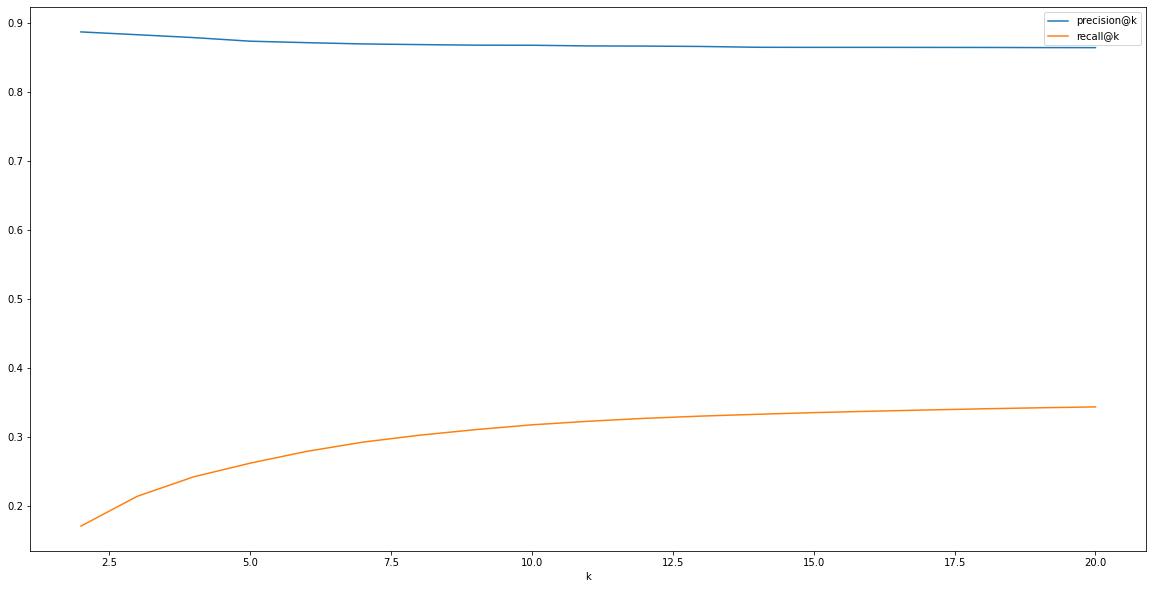

In [21]:
pd.DataFrame(np.array([ks, precs_k_list, recs_k_list]).T, columns = ['k', 'precision@k', 'recall@k']).set_index('k').plot(figsize = (20, 10))